<img src="./pictures/logo_sizinglab.png" style="float:right; max-width: 60px; display: inline" alt="SizingLab" /></a>


# Propellers estimation models with dimensional analysis and linear regressions

*Written by Marc Budinger (INSA Toulouse), Scott Delbecq (ISAE-SUPAERO) and Félix Pollet (ISAE-SUPAERO), Toulouse, France.*

Propellers characteristics can be expressed by $C_T$ and $C_P$ coefficients. These coefficients are function of dimensions and conditions of use of propellers.  Dimensional analysis and linear regression of suppliers data can be used for the generation of $C_T$ and $C_P$ prediction models. 

```{figure} https://raw.githubusercontent.com/SizingLab/sizing_course/main/laboratories/Lab-multirotor/assets/images/apc-mr-props.jpg
:name: apc_mr_prop
:align: center
:width: 25%

APC MR (Multi-Rotor) propellers
```


## Dimensional analysis and $\pi$ numbers

The propeller performances can be expressed with 2 aerodynamic coefficients:
- The thrust: $F = C_{T} \rho_{air} n^2 D^4$  
- The power: $P = C_{P} \rho_{air} n^3 D^5 $

The [dimensional analysis](https://web.mit.edu/16.unified/www/FALL/thermodynamics/notes/node86.html#SECTION06374000000000000000) and especially the [Buckingham $\pi$ theorem](https://en.wikipedia.org/wiki/Buckingham_%CF%80_theorem) enable to find this results.


#### Dimensional analysis of the propeller thrust  

The thrust $F$ of a propeller depends of multiple parameters (geometrical dimensions, air properties, operational points):  
$F=f(\rho_{air},n,D,p,V,\beta_{air})$   
with the parameters express in the following table.

Parameter|M|L|T|
--|--|--|--
Thrust $T$ [N] | 1|1|-2
Mass volumic (Air) $\rho_{air}$ [kg/m$^3$]| 1 | -3 | 0|
Rotational speed $n$ [Hz] | 0 | 0 | -1|
Diameter $D$ [m] | 0| 1 | 0|
Pitch $p$ [m] | 0 | 1 | 0|
Drone speed $V$ [m/s] | 0 | 1 | -1|
Bulk modulus (Air) $\beta_{air}$ [Pa] | 1 | -1 | -2|
$\frac{F}{\rho n^2 D^4}=\pi_0$|  |  |  |
$\frac{F}{\beta p^2}=\pi_1$|  |  |  |
$p/D=\pi_2$|  |  |  |
$pn/V=\pi_3$|  |  |  |


**Remark**: The dimension of a parameter $x$ is function of dimensions L, M and T : $[x]=M^aL^bT^c$.  The previous table gives the value of $a$, $b$ and $c$ for each parameter of the problem. 

```{exercise}
:label: exercice_pi

Complete the table with 4 dimensionless $\pi$ numbers possible for the given problem. Explain the number of dimensionless number.
```

Parameter|M|L|T|
--|--|--|--
Thrust $T$ [N] | 1|1|-2
Mass volumic (Air) $\rho_{air}$ [kg/m$^3$]| 1 | -3 | 0|
Rotational speed $n$ [Hz] | 0 | 0 | -1|
Diameter $D$ [m] | 0| 1 | 0|
Pitch $p$ [m] | 0 | 1 | 0|
Drone speed $V$ [m/s] | 0 | 1 | -1|
Bulk modulus (Air) $\beta_{air}$ [Pa] | 1 | -1 | -2|
$=\pi_0$|  |  |  |
$=\pi_1$|  |  |  |
$=\pi_2$|  |  |  |
$=\pi_3$|  |  |  |

#### Effect of the rotational speed  

APC suppliers give complete [propeller data](https://www.apcprop.com/technical-information/) for all their propellers. From the file *APC_STATIC-data-all-props.csv*, we find all static data provided by APC:

In [1]:
import pandas as pd

# Read the .csv file with bearing data
path = "https://raw.githubusercontent.com/SizingLab/sizing_course/main/laboratories/Lab-multirotor/assets/data/"
df = pd.read_csv(path + "APC_STATIC-data-all-props.csv", sep=";")
# Print the head (first lines of the file)
df.head()

,LINE,COMP,TYPE,RPM,DIAMETER(IN),PITCH(IN),BLADE(nb),THRUST(LBF),POWER(HP),TORQUE(IN.LBF),Cp,Ct,AREA(m^2),THRUST(N),POWER(W),ANGLE,EFF,N.D
0,1,1,NaN,1000,10.5,4.5,2,0.03,0.01,0.02,0.03,0.08,0.06,0.1335,7.457,0.43,60.180222,10500.0
1,2,1,NaN,2000,10.5,4.5,2,0.13,0.01,0.08,0.03,0.08,0.06,0.5785,7.457,0.43,60.180222,21000.0
2,3,1,NaN,3000,10.5,4.5,2,0.29,0.01,0.17,0.03,0.08,0.06,1.2905,7.457,0.43,60.180222,31500.0
3,4,1,NaN,4000,10.5,4.5,2,0.52,0.02,0.30,0.03,0.08,0.06,2.3140,14.914,0.43,60.180222,42000.0
4,5,1,NaN,5000,10.5,4.5,2,0.81,0.04,0.47,0.03,0.08,0.06,3.6045,29.828,0.43,60.180222,52500.0


For next steps, we keep only the Multi-Rotor type propellers (MR). 

In [2]:
# Data Filtering
dfMR = df[df["TYPE"] == "MR"]
dfMR.head()

,LINE,COMP,TYPE,RPM,DIAMETER(IN),PITCH(IN),BLADE(nb),THRUST(LBF),POWER(HP),TORQUE(IN.LBF),Cp,Ct,AREA(m^2),THRUST(N),POWER(W),ANGLE,EFF,N.D
135,147,8,MR,2000,10.0,4.5,2,0.14,0.01,0.09,0.04,0.11,0.05,0.6230,7.457,0.45,72.772802,20000.0
146,148,8,MR,3000,10.0,4.5,2,0.32,0.01,0.20,0.04,0.11,0.05,1.4240,7.457,0.45,72.772802,30000.0
147,149,8,MR,4000,10.0,4.5,2,0.57,0.02,0.36,0.04,0.11,0.05,2.5365,14.914,0.45,72.772802,40000.0
148,150,8,MR,5000,10.0,4.5,2,0.90,0.04,0.56,0.04,0.11,0.05,4.0050,29.828,0.45,72.772802,50000.0
149,151,8,MR,6000,10.0,4.5,2,1.29,0.08,0.79,0.04,0.11,0.05,5.7405,59.656,0.45,72.772802,60000.0


We plot the $C_p$ and $C_t$ for the a 10x4.5 propeller (COMP n° 8 in the previous table). We can notice that these coefficients are constant up to a certain value of speed of rotation. The manufacturer recommends using these propellers for a product speed of rotation x diameter less than a limit (depending on the type of propeller technology) and given [here](https://www.apcprop.com/technical-information/rpm-limits/):  
Maximum speed(RPM) x prop diameter (inches) = 105,000  
for MR type which gives a blade tip speed of 135 m/s. The dark spots on the following diagram correspond to this non-recommended operating zone.

> **Question:** Explain the origin of this operating limit comes from and the $\pi$ number that can express it.


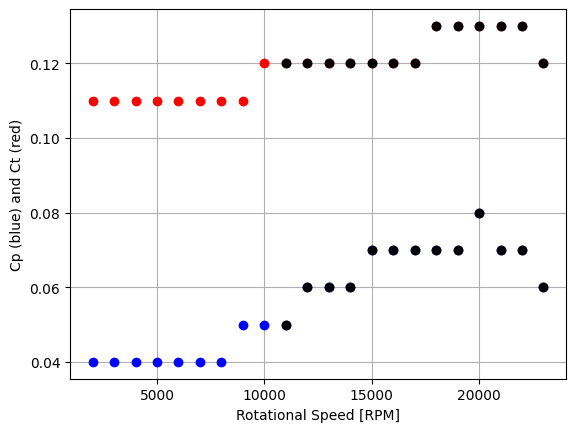

In [3]:
# Keep only the component n°8
df8 = dfMR[dfMR["COMP"] == 8]

# Extract forbidden ND product
df8ND = df8[df8["N.D"] > 105000]

import numpy as np
import matplotlib.pyplot as plt

# plot the data
plt.plot(
    df8["RPM"],
    df8["Cp"],
    "bo",
    df8["RPM"],
    df8["Ct"],
    "ro",
)
plt.plot(
    df8ND["RPM"],
    df8ND["Cp"],
    "ko",
    df8ND["RPM"],
    df8ND["Ct"],
    "ko",
)
plt.xlabel("Rotational Speed [RPM]")
plt.ylabel("Cp (blue) and Ct (red)")
plt.grid()
plt.show()

## Linear regression

For next calculations, we keep only data with following criteria:
-  Type 'MR' (Multi-Rotor)    
-  Maximum RPM < 105,000/prop diameter (inches)

In [6]:
# Keep only operating points with ND<105000
df_MR_ND = dfMR[dfMR["N.D"] < 105000]

The APC static data correspond to the hover operational point where the speed V=0. The aerodynamic coefficients are thus only a function of $p/D$ (called 'ANGLE' in the .csv file) dimensionless number.

$C_t=\frac{F}{\rho_{air} n^2 D^4}=f(\frac{p}{D})$  
$C_p=\frac{P}{\rho_{air} n^3 D^5}=g(\frac{p}{D})$  

The following code uses the [Scikit-learn](https://scikit-learn.org/stable/) package in order to set up a $C_t$ estimator for the static case ($V=0$ or $J=0$).

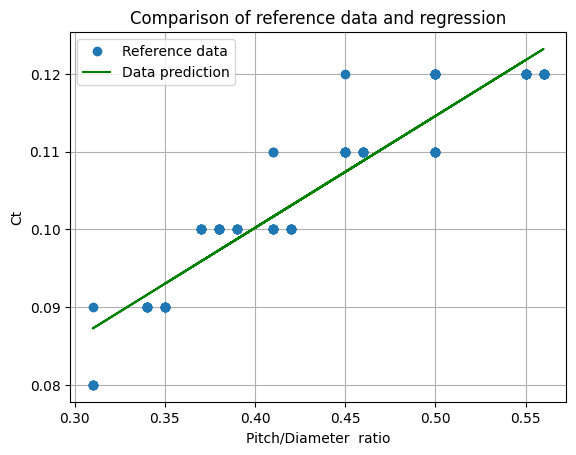

Ct estimation model : Ct = 0.04 + 0.14 * p/D with R2=0.895


In [7]:
# Import packages
from sklearn import linear_model
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


# Data
x = df_MR_ND["ANGLE"].values
y_Ct = df_MR_ND["Ct"].values

# Matrix X and Y
X = x.reshape(-1, 1)

Y_Ct = y_Ct.reshape(-1, 1)

# Create a new object for the linear regression
reg_Ct = linear_model.LinearRegression()

reg_Ct.fit(X, Y_Ct)


# Y vector prediction
Ct_est = reg_Ct.predict(X)

# Ct Parameters
# ----
coef = float(reg_Ct.coef_)
intercept = float(reg_Ct.intercept_)
r2 = r2_score(Y_Ct, Ct_est)


# Plot the data
plt.plot(x, Y_Ct, "o", label="Reference data")
plt.plot(x, Ct_est, "-g", label="Data prediction")
plt.xlabel("Pitch/Diameter  ratio")
plt.ylabel("Ct")
plt.title("Comparison of reference data and regression")
plt.legend()
plt.grid()
plt.show()

print(f"Ct estimation model : Ct = {intercept:.2f} + {coef:.2f} * p/D with R2={r2:.3f}")

```{exercise}
:label: exercice_cp

Perform a linear regression of $C_p$ data.
```

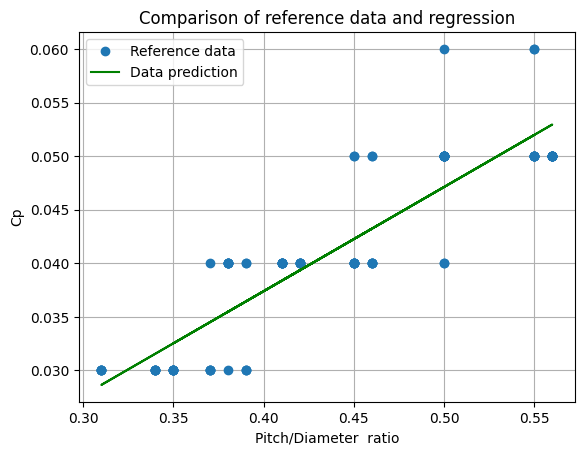

Cp estimation model : Cp = -0.00 + 0.10 * p/D with R2=0.798


In [12]:
y_Cp = df_MR_ND["Cp"].values
X = x.reshape(-1, 1)
Y_Cp = y_Cp.reshape(-1, 1)

reg_Cp = linear_model.LinearRegression()

reg_Cp.fit(X, Y_Cp)
Cp_est = reg_Cp.predict(X)



# Cp Parameters 
# -----
coef = float(reg_Cp.coef_)
intercept = float(reg_Cp.intercept_)
r2 = r2_score(Y_Cp, Cp_est)


# Plot the data 
plt.plot(x, Y_Cp, 'o', label='Reference data')
plt.plot(x, Cp_est, '-g', label='Data prediction')
plt.xlabel('Pitch/Diameter  ratio')
plt.ylabel('Cp')
plt.title('Comparison of reference data and regression')
plt.legend()
plt.grid()
plt.show()

print(f"Cp estimation model : Cp = {intercept:.2f} + {coef:.2f} * p/D with R2={r2:.3f}")